In [1]:
%matplotlib inline

In [2]:
import numpy as np
from IPython.display import Image
from fatiando.vis import mpl, myv

In [3]:
mpl.rcParams['font.size'] = 16

In [4]:
import functions as f

### Load data from txt files

In [5]:
files = ['data0.txt', 
         'data1.txt',
         'data2.txt',
         'data3.txt']

nfiles = len(files)

In [6]:
data = []

for i in range(nfiles):
    data.append(np.loadtxt(files[i]))

### Parameters of the sample

In [7]:
N = 16 # number of prisms forming the sample
M = 3*N # number of parameters to be estimated

Lx = 0.001 # in m
Ly = 0.003 # in m
Lz = Ly  # in m

shape = (42,102)
#shape = (102,42)

In [8]:
xmin_sample = -0.5*Lx*N #in m
centers = [100.*(xmin_sample + 0.5*Lx + i*Lx) for i in range(N)] #in cm
centers = np.array(centers)

### Interpretation model

In [9]:
model = f.sample(Lx,Ly,Lz,N)

In [10]:
xmin = np.min([data[0][:,0], data[1][:,0], data[2][:,0], data[3][:,0]])
xmax = np.max([data[0][:,0], data[1][:,0], data[2][:,0], data[3][:,0]])
ymin = np.min([data[0][:,1], data[1][:,1], data[2][:,1], data[3][:,1]])
ymax = np.max([data[0][:,1], data[1][:,1], data[2][:,1], data[3][:,1]])
zmin = np.min([data[0][:,2], data[1][:,2], data[2][:,2], data[3][:,2]])
zmax = np.max([data[0][:,2], data[1][:,2], data[2][:,2], data[3][:,2]])

volume = [xmin, xmax, ymin, ymax, zmin, zmax]

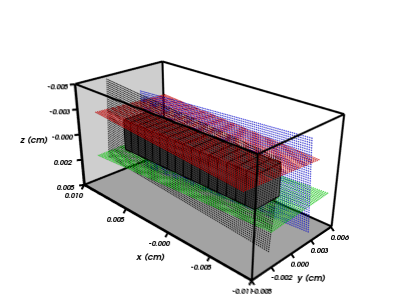

In [11]:
scene = myv.figure()
myv.prisms(model, color= (0.4,0.4,0.4))

myv.points(np.vstack((data[0][:,0], data[0][:,1], data[0][:,2])).T, 
           color=(1, 0, 0), size=0.00005, opacity=1, spherical=False)
myv.points(np.vstack((data[1][:,0], data[1][:,1], data[1][:,2])).T, 
           color=(0, 0, 1), size=0.00005, opacity=1, spherical=False)
myv.points(np.vstack((data[2][:,0], data[2][:,1], data[2][:,2])).T, 
           color=(0, 1, 0), size=0.00005, opacity=1, spherical=False)
myv.points(np.vstack((data[3][:,0], data[3][:,1], data[3][:,2])).T, 
           color=(0, 0, 0), size=0.00005, opacity=1, spherical=False)



ax = myv.axes(myv.outline(volume), ranges=[b for b in volume], nlabels=5, fmt='%.3f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (cm)', 'y (cm)', 'z (cm)'
ax.axes.font_factor = 1.2
myv.wall_bottom(ax.axes.bounds, opacity=0.2)
myv.wall_north(ax.axes.bounds)
myv.savefig('model.png')
myv.show()
Image(filename='model.png')

### Inversion

In [12]:
B_obs = []
for i in range(4):
    B_obs.append(data[i][:,3])

In [13]:
A = []
for i in range(4):
    A.append(f.sensitivity(N, data[i][:,0], data[i][:,1], data[i][:,2], model,i))

In [14]:
R = np.zeros(M+1)
R[0] = 1.
R[3] = -1.
R = np.resize(R, (M-3,M))

In [15]:
u0 = 0.

In [16]:
H = np.dot(np.vstack(A).T, np.vstack(A))

In [17]:
f0 = np.trace(H)/M
f0

12526138.706979195

In [18]:
H = H + u0*f0*np.dot(R.T, R)

In [19]:
h = np.dot(np.vstack(A).T, np.hstack(B_obs))

In [20]:
p_est = np.linalg.solve(H, h)

In [21]:
p_est = f.L2_norm(np.vstack(A),np.hstack(B_obs))
#p_est = f.L2_norm(np.vstack((A[1],A[2],A[3])),np.hstack((B_obs[1],B_obs[2], B_obs[3])))
#p_est = f.L2_norm(np.vstack((A[0],A[1],A[2])),np.hstack((B_obs[0],B_obs[1], B_obs[2])))
#p_est = f.L2_norm(np.vstack((A[1],A[2])),np.hstack((B_obs[1],B_obs[2])))
#p_est = f.L2_norm(np.array(A[1]),np.array(B_obs[1]))
#p_est = f.L2_norm(np.array(A[0]),np.array(B_obs[0]))

In [22]:
mag_r = f.parameters_sph(N,p_est)

In [23]:
print mag_r

[[  129.92212305    17.37365372    40.14389696]
 [  672.23611424    26.62932371   169.86927877]
 [  989.74406471    30.24831388   170.66380672]
 [  995.30655873    24.85232948   168.06939836]
 [  564.86694529    62.97998876   127.54028482]
 [ 1349.63650077    56.34603483     9.2497046 ]
 [ 1097.40121185    44.19062928    13.07605564]
 [ 1151.47207919    54.95238059    14.69709769]
 [  355.92524916   -13.03438762     5.82443935]
 [ 1283.29386409   -76.24576727    -5.77768646]
 [ 1130.91747544   -75.23990931    -3.94762734]
 [ 1315.05326492   -74.31211887    -7.40492882]
 [  287.10237326    62.66330394    39.55040221]
 [ 1232.04768179    85.53765945    76.94846392]
 [ 1243.42849492    84.54093971    43.78796229]
 [ 1126.42338646    83.85192664   159.84944246]]


In [24]:
np.savetxt('estimate_real.txt', np.array(mag_r), fmt='%.5f')

In [25]:
B_pre = []
for i in range(4):
    B_pre.append(np.dot(A[i],p_est))

In [26]:
r_norm = []
r_mean = []
r_std = []

for i in range(4):
    aux1,aux2,aux3 = f.residual(0.001*B_obs[i],0.001*B_pre[i])
    r_norm.append(aux1) # in uT
    r_mean.append(aux2) # in uT
    r_std.append(aux3)  # in uT

### Plotting of the observed and predicted data 

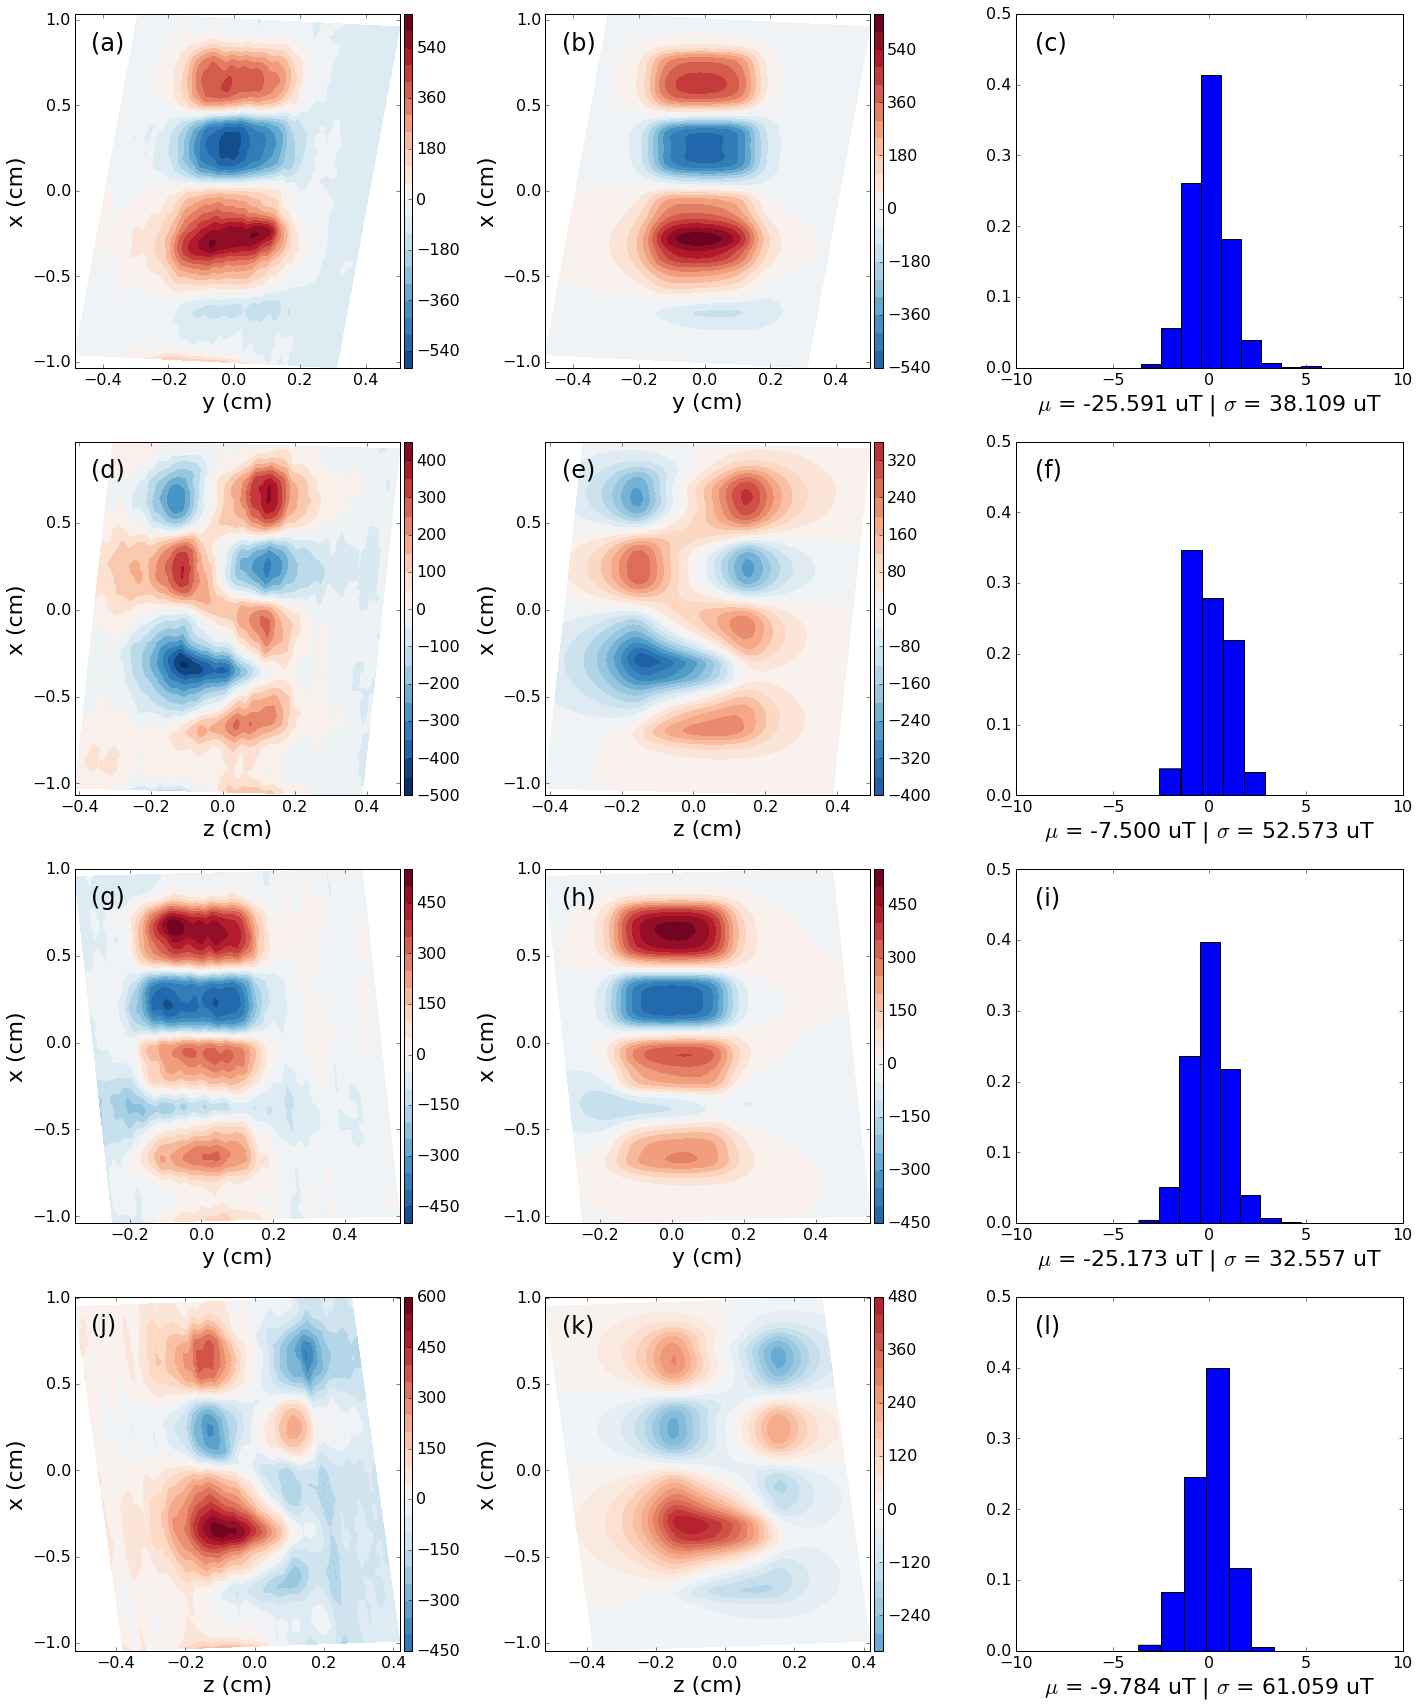

In [32]:
title_font = 22
bottom_font = 16

labels = ['(a)', '(b)', '(c)', 
          '(d)', '(e)', '(f)',
          '(g)', '(h)', '(i)',
          '(j)', '(k)', '(l)']

lables_place = (0.05, 0.90)
lables_size = 24

mpl.close('all')
mpl.figure(figsize=(20,24), tight_layout=True)

for i in range(0,4,2):

    # in uT
    ranges = 0.001*np.abs([B_obs[i].max(), B_obs[i].min(),
                           B_pre[i].max(), B_pre[i].min()]).max()

    mpl.subplot(4,3,1 + 3*i)

    #mpl.title(labels[3*i], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,1], 100.*data[i][:,0], 0.001*B_obs[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('y (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 1)

    #mpl.title(labels[3*i + 1], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,1], 100.*data[i][:,0], 0.001*B_pre[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('y (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i + 1], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 2)
    #mpl.title(labels[3*i + 2], fontsize=title_font)
    mpl.xlabel('$\mu$ = %.3f uT | $\sigma$ = %.3f uT' % (r_mean[i], r_std[i]), fontsize = title_font)
    nbins = int((np.max(r_norm[i]) - np.min(r_norm[i])))
    mpl.hist(r_norm[i],bins=nbins,normed=True)
    mpl.ylim(0.,0.5)
    mpl.xlim(-10., 10.)
    mpl.annotate(labels[3*i + 2], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)
    
for i in range(1,4,2):

    # in uT
    ranges = 0.001*np.abs([B_obs[i].max(), B_obs[i].min(),
                           B_pre[i].max(), B_pre[i].min()]).max()

    mpl.subplot(4,3,1 + 3*i)

    #mpl.title(labels[3*i], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,2], 100.*data[i][:,0], 0.001*B_obs[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('z (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 1)

    #mpl.title(labels[3*i + 1], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,2], 100.*data[i][:,0], 0.001*B_pre[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('z (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i+1], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 2)
    #mpl.title(labels[3*i + 2], fontsize=title_font)
    mpl.xlabel('$\mu$ = %.3f uT | $\sigma$ = %.3f uT' % (r_mean[i], r_std[i]), fontsize = title_font)
    nbins = int((np.max(r_norm[i]) - np.min(r_norm[i])))
    mpl.hist(r_norm[i],bins=nbins,normed=True)
    mpl.ylim(0.,0.5)
    mpl.xlim(-10., 10.)
    mpl.annotate(labels[3*i+2], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

mpl.savefig('../../manuscript/Figs/Fig14_LQ.png')
mpl.savefig('../../manuscript/Figs/Fig14_HQ.eps')

mpl.show()

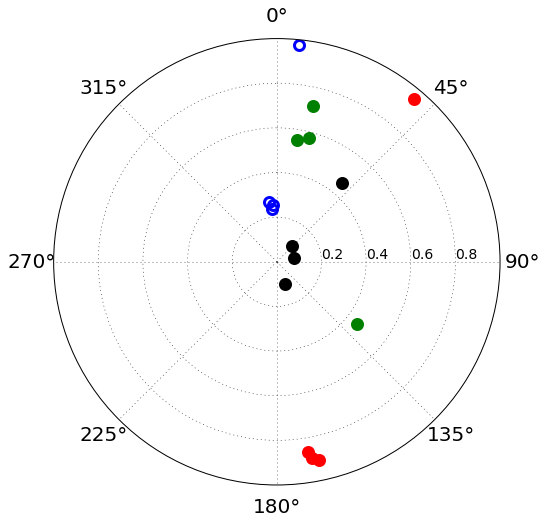

In [28]:
mpl.figure(figsize=(8,8))
ax = mpl.subplot(111, polar=True)
ax.set_theta_direction(-1) 
ax.set_theta_zero_location('N') 
ax.set_rgrids([0.2,0.4,0.6,0.8], angle=90.)

f.proj_polar(4,mag_r[:4,:],color='r')
f.proj_polar(4,mag_r[4:8,:],color='g')
f.proj_polar(4,mag_r[8:12,:],color='b')
f.proj_polar(4,mag_r[12:16,:],color='k')

mpl.xticks(fontsize=20) 
mpl.yticks(fontsize=14) 
mpl.ylim(0.0, 1.0)
#mpl.savefig('estimate_polar_real.png')
mpl.show() 

In [29]:
non_spurious = np.array([True for i in range(N)])
non_spurious[::4] = False

spurious = np.array([False for i in range(N)])
spurious[::4] = True

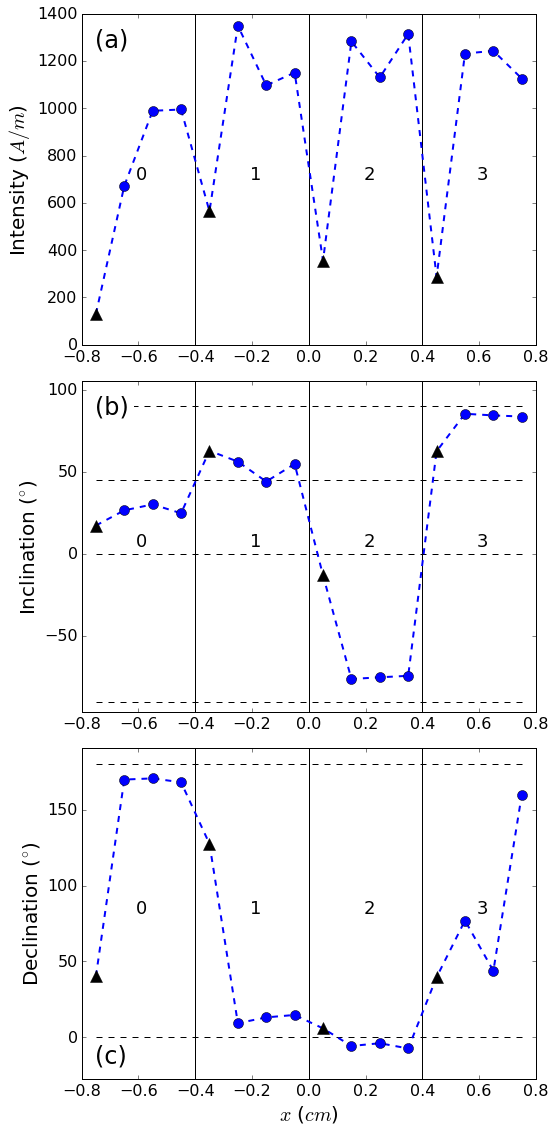

In [33]:
label_font = 20
legend_font = 16

labels = ['(a)', '(b)', '(c)']

lables_place = (0.03, 0.90)
lables_size = 24

mpl.show()
mpl.close('all')
mpl.figure(figsize=(8, 16), tight_layout=True)

mpl.subplot(3,1,1)
mpl.plot([-400.*Lx, -400.*Lx], [0., 1500.0], 'k-')
mpl.plot([0., 0.], [0., 1500.0], 'k-')
mpl.plot([400.*Lx, 400.*Lx], [0., 1500.0], 'k-')
mpl.plot([np.min(centers), np.max(centers)], [0.0, 0.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [1200.0, 1200.0], 'k--',
#         label='Saturation magnetization')
mpl.plot(centers, mag_r[:,0], 'b--', linewidth=2)
mpl.plot(centers[non_spurious], mag_r[non_spurious,0], 'bo', markersize=10)
mpl.plot(centers[spurious], mag_r[spurious,0], 'k^', markersize=12)
mpl.ylabel('Intensity ($A/m$)', fontsize=label_font)
mpl.ylim(0., np.max(mag_r[:,0]) + 50.)
#mpl.legend(loc='best', numpoints=1)
mpl.annotate(labels[0], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)
mpl.annotate('0', xy = (0.12, 0.5), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('1', xy = (0.37, 0.5), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('2', xy = (0.62, 0.5), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('3', xy = (0.87, 0.5), 
                 xycoords = 'axes fraction', fontsize=18)

mpl.subplot(3,1,2)
mpl.plot([-400.*Lx, -400.*Lx], [-180., 180.0], 'k-')
mpl.plot([0., 0.], [-180., 180.0], 'k-')
mpl.plot([400.*Lx, 400.*Lx], [-180., 180.0], 'k-')
mpl.plot([np.min(centers), np.max(centers)], [0.0, 0.0], 'k--')
mpl.plot([np.min(centers), np.max(centers)], [45.0, 45.0], 'k--')
mpl.plot([np.min(centers), np.max(centers)], [-90.0, -90.0], 'k--')
mpl.plot([np.min(centers), np.max(centers)], [90.0, 90.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [45.0, 45.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [90.0, 90.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [-90.0, -90.0], 'k--')
mpl.plot(centers, mag_r[:,1], 'b--', linewidth=2)
mpl.plot(centers[non_spurious], mag_r[non_spurious,1], 'bo', markersize=10)
mpl.plot(centers[spurious], mag_r[spurious,1], 'k^', markersize=12)
mpl.ylabel('Inclination ($^{\circ}$)', fontsize=label_font)
mpl.ylim(np.min(mag_r[:,1]) - 20., np.max(mag_r[:,1]) + 20.)
#mpl.legend(loc='best', numpoints=1)
mpl.annotate(labels[1], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size,
                 backgroundcolor = 'w')
mpl.annotate('0', xy = (0.12, 0.5), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('1', xy = (0.37, 0.5), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('2', xy = (0.62, 0.5), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('3', xy = (0.87, 0.5), 
                 xycoords = 'axes fraction', fontsize=18)

mpl.subplot(3,1,3)
mpl.plot([-400.*Lx, -400.*Lx], [-180., 200.0], 'k-')
mpl.plot([0., 0.], [-180., 200.0], 'k-')
mpl.plot([400.*Lx, 400.*Lx], [-180., 200.0], 'k-')
mpl.plot([np.min(centers), np.max(centers)], [0.0, 0.0], 'k--')
mpl.plot([np.min(centers), np.max(centers)], [180.0, 180.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [180.0, 180.0], 'k--')
mpl.plot(centers, mag_r[:,2], 'b--', linewidth=2)
mpl.plot(centers[non_spurious], mag_r[non_spurious,2], 'bo', markersize=10)
mpl.plot(centers[spurious], mag_r[spurious,2], 'k^', markersize=12)
mpl.ylabel('Declination ($^{\circ}$)', fontsize=label_font)
#mpl.xlabel('Sample length ($cm$)', fontsize=label_font)
mpl.xlabel('$x$ ($cm$)', fontsize=label_font)
mpl.ylim(np.min(mag_r[:,2]) - 20., np.max(mag_r[:,2]) + 20.)
#mpl.savefig('estimate_int_inc_dec_simul_validation.eps')
#mpl.legend(loc='best', numpoints=1)
mpl.annotate(labels[2], xy = (0.03, 0.05), 
                 xycoords = 'axes fraction', fontsize=lables_size,
                 backgroundcolor = 'w')
mpl.annotate('0', xy = (0.12, 0.5), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('1', xy = (0.37, 0.5), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('2', xy = (0.62, 0.5), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('3', xy = (0.87, 0.5), 
                 xycoords = 'axes fraction', fontsize=18)

mpl.savefig('../../manuscript/Figs/Fig15_LQ.png')
mpl.savefig('../../manuscript/Figs/Fig15_HQ.eps')

mpl.show()

### Discussion

The synthetic sample is formed by four justaposed cubes along the x diretion. The interpretation model used in this simulation is formed by 16 prisms, so that each cube of the original synthetic sample is described by four prisms. 